In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

import time

random_state = 6
np.random.seed(random_state)
warnings.filterwarnings('ignore')

/anaconda/envs/myenv/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib inline
get_ipython().run_line_magic('matplotlib', 'inline')

# latex parameter
font = {
    'family': 'serif', 
    'serif': ['Computer Modern Roman'],
    'weight' : 'regular',
    'size'   : 18
    }

plt.rc('font', **font)
plt.rc('text', usetex=False)
# plt.style.use('classic')

color_map = 'viridis'

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

### Check if both test and train have the same shape

In [4]:
print('Training data shape: {}'.format(df_train.shape))
print('Training data shape: {}'.format(df_test.shape))

Training data shape: (595212, 59)
Training data shape: (892816, 58)


### Check if there are any missing values

In [5]:
print('Is null on train: {}'.format(df_train.isnull().any().any()))
print('Is null on test: {}'.format(df_test.isnull().any().any()))

Is null on train: False
Is null on test: False


### Descriptive statistics

In [6]:
df_train.describe()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,5.952120e+05,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,4.293678e+05,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,7.000000e+00,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.115549e+06,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.488027e+06,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Heatmap 

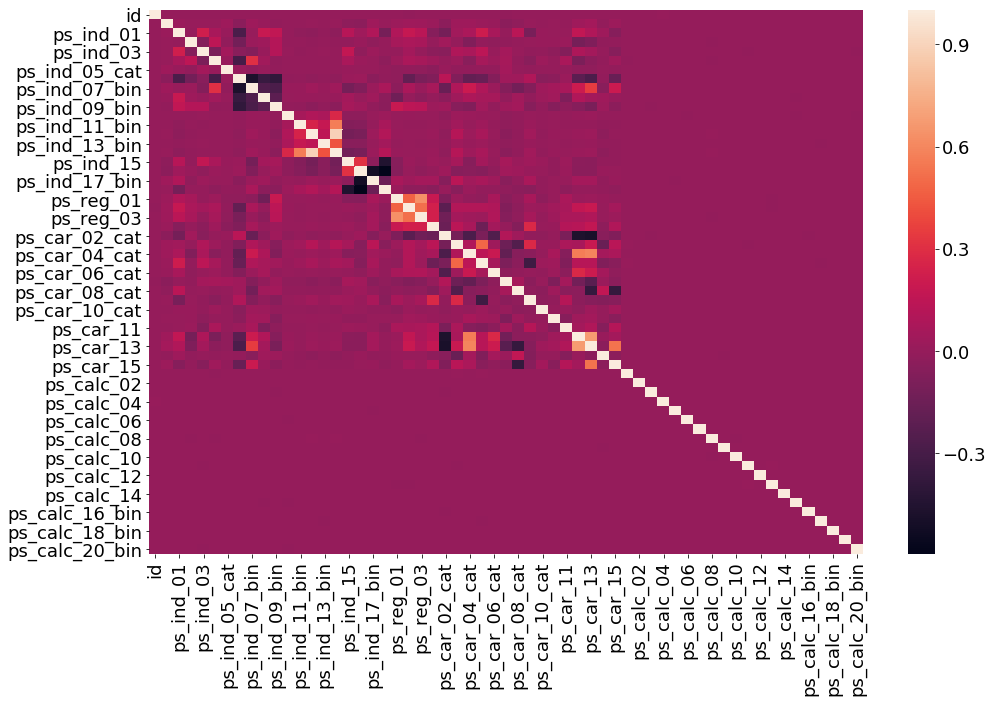

In [7]:
import seaborn as sns
cor = df_train.corr()
plt.figure(figsize=(16,10))
sns.heatmap(cor)

#### Since 'ps_calc' features do not show any have zero relationship with other features
#### We can delete them.

In [8]:
col_to_drop = list(df_train.columns[df_train.columns.str.startswith('ps_calc_')])
df_train = df_train.drop(col_to_drop, axis=1)  
df_test = df_test.drop(col_to_drop, axis=1)

### Treat missing values by mean of the column

In [14]:
for i, feature in enumerate(list(df_train.drop(['id'], axis=1))):
    if df_train[feature].isnull().sum() > 0:
        df_train[feature].fillna(df_train[feature].mode()[0],inplace=True)

for i, feature in enumerate(list(df_test.drop(['id'], axis=1))):
    if df_test[feature].isnull().sum() > 0:
        df_test[feature].fillna(df_test[feature].mode()[0],inplace=True)

## Check category features of the dataset

In [ ]:
cat_cols = [col for col in df_train.columns if '_cat' in col]
dummed_cols = []

for cat_col in cat_cols:
    unique_values = len(np.unique(df_train[cat_col]))
    if unique_values < 50:
        dummed_cols.append(cat_col)
    print('{} has {} unique values'.format(cat_col, unique_values))

## Transform category features to dummies

In [16]:
id_test = df_test['id'].values
y = df_train['target'].values

df_train = df_train.drop(['target','id'], axis = 1)
df_test = df_test.drop(['id'], axis = 1)

cat_features = [a for a in df_train.columns if a.endswith('cat')]

for column in cat_features:
    temp = pd.get_dummies(pd.Series(df_train[column]))
    df_train = pd.concat([df_train,temp],axis=1)
    df_train = df_train.drop([column],axis=1)
    
for column in cat_features:
    temp = pd.get_dummies(pd.Series(df_test[column]))
    df_test = pd.concat([df_test,temp],axis=1)
    df_test = df_test.drop([column],axis=1)

print(df_train.values.shape, df_test.values.shape)

(595212, 207) (892816, 207)


### Gini coeficient 

In [18]:
# from https://www.kaggle.com/mashavasilenko/
# porto-seguro-xgb-modeling-and-parameters-tuning
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini


def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    return [('gini', gini_score)]

def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

### Ensembling

In [19]:
from sklearn.model_selection import StratifiedKFold

class Create_ensemble(object):
    def __init__(self, n_splits, base_models):
        self.n_splits = n_splits
        self.base_models = base_models

    def predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=2016).split(X, y))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        
        for i, clf in enumerate(self.base_models):
            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, valid_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_valid = X[valid_idx]
                y_valid = y[valid_idx]
                
                clf.fit(X_train, y_train)
                valid_pred = clf.predict_proba(X_valid)[:,1]
                S_train[valid_idx, i] = valid_pred
                S_test_i[:, j] = clf.predict_proba(T)[:,1]
            
            print( "\nTraining Gini for model {} : {}".format(i, eval_gini(y, S_train[:,i])))
            S_test[:, i] = S_test_i.mean(axis=1)
            
        return S_train, S_test

## Lightbm model

In [20]:
# LightGBM params
lgb_params = {}
lgb_params['learning_rate'] = 0.02
lgb_params['n_estimators'] = 700
lgb_params['max_bin'] = 15
lgb_params['subsample'] = 0.8
lgb_params['subsample_freq'] = 10
lgb_params['colsample_bytree'] = 0.8   
lgb_params['min_child_samples'] = 800
lgb_params['random_state'] = 99
lgb_params['scale_pos_weight'] = 3

lgb_params2 = {}
# learning_rate, default=0.1, type=double, alias=shrinkage_rate
# shrinkage rate
# in dart, it also affects on normalization weights of dropped trees
lgb_params2['learning_rate'] = 0.02

# number of trees
lgb_params2['n_estimators'] = 900

# max_bin, default=255, type=int
# max number of bins that feature values will be bucketed in. 
# Small number of bins may reduce training accuracy but may increase general power (deal with over-fitting)
# LightGBM will auto compress memory according max_bin. 
# For example, LightGBM will use uint8_t for feature value if max_bin=255
lgb_params2['max_bin'] = 20

# bagging_fraction, default=1.0, type=double, 0.0 < bagging_fraction < 1.0, alias=sub_row, subsample
# like feature_fraction, but this will randomly select part of data without resampling
# can be used to speed up training
# can be used to deal with over-fitting
# Note: To enable bagging, bagging_freq should be set to a non zero value as well
lgb_params2['subsample'] = 0.8

# bagging_freq, default=0, type=int, alias=subsample_freq
# frequency for bagging, 0 means disable bagging. k means will perform bagging at every k iteration
# Note: to enable bagging, bagging_fraction should be set as well
lgb_params2['subsample_freq'] = 10

# feature_fraction, default=1.0, type=double, 0.0 < feature_fraction < 1.0, alias=sub_feature, colsample_bytree
# LightGBM will randomly select part of features on each iteration if feature_fraction smaller than 1.0. 
# For example, if set to 0.8, will select 80% features before training each tree
# can be used to speed up training
# can be used to deal with over-fitting
lgb_params2['colsample_bytree'] = 0.8 

# minimal number of data in one leaf. Can be used to deal with over-fitting
lgb_params2['min_child_samples'] = 600

# for seeds
lgb_params2['random_state'] = 99

# scale_pos_weight, default=1.0, type=double
# weight of positive class in binary classification task
lgb_params2['scale_pos_weight'] = 3

lgb_model = LGBMClassifier(**lgb_params)
lgb_model2 = LGBMClassifier(**lgb_params2)

In [21]:
lgb_stack = Create_ensemble(n_splits = 5, base_models = [lgb_model, lgb_model2])        
X = df_train
Y = y
T = df_test
lgb_train_pred, lgb_test_pred = lgb_stack.predict(X, Y, T)


Training Gini for model 0 : 0.2857873719592655

Training Gini for model 1 : 0.2855167423819919


In [22]:
# Create submission file
sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = lgb_test_pred.mean(axis=1)
sub.to_csv('lightgbm_submit_ensemble_features.csv', float_format='%.6f', index=False)

## correlation among the models

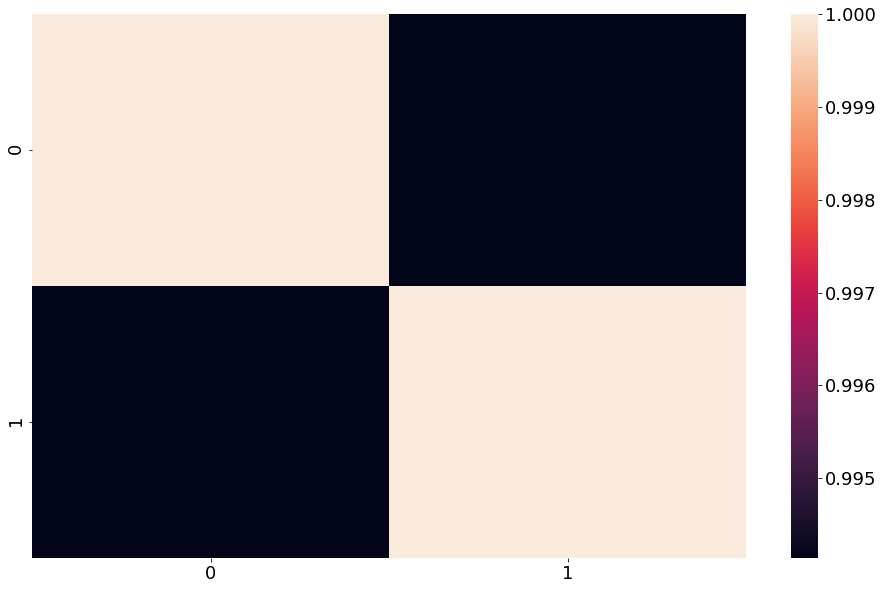

In [23]:
import seaborn as sns
test_pred_df = pd.DataFrame(data = lgb_test_pred)
cor = test_pred_df.corr()
plt.figure(figsize=(16,10))
sns.heatmap(cor)